In [1]:
import scanpy
import anndata
import matplotlib
from matplotlib import pyplot
import hdf5plugin
import numpy
import scvelo
import seaborn
import pandas
import warnings
import cellrank
import pygam
import gseapy

In [2]:
# Read input file

working_directory = "Data/"

# Use adata from velocity analysis
adata = scanpy.read_h5ad(working_directory + "/velocity_unitvelo.h5ad")

print(adata)

AnnData object with n_obs × n_vars = 16146 × 2104
    obs: 'leiden_0.6', 'leiden_0.2_c6', 'sample', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_ids', 'fit_likelihood', 'velocity_gamma', 'velocity_r2', 'scaling', 'velocity_genes', 'fit_vars', 'fit_varu', 'fit_gamma', 'fit_beta', 'fit_offset', 'fit_a', 'fit_t', 'fit_h', 'fit_intercept', 'fit_loss', 'fit_llf', 'fit_sr2', 'fit_ur2'
    uns: 'base_function', 'basis', 'datapath', 'label', 'leiden_0.2_c6_colors', 'leiden_0.6_colors', 'loss', 'neighbors', 'par_names', 'pca', 'sample_colors', 'temp', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'Mu_scale', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'


In [3]:
# Suppress warnings

warnings.simplefilter("ignore", category=UserWarning)

In [11]:
# Exclude the problematic clusters 12, 14 and 20
adata = adata[~((adata.obs["leiden_0.2_c6"]=="12") | (adata.obs["leiden_0.2_c6"]=="14") | (adata.obs["leiden_0.2_c6"]=="20"))]

In [12]:
# Create velocity kernel

velocity_kernel = cellrank.kernels.VelocityKernel(adata, vkey="velocity")
velocity_kernel.compute_transition_matrix()

  0%|          | 0/15406 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/15406 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


VelocityKernel[n=15406, model='deterministic', similarity='correlation', softmax_scale=4.43]

In [13]:
# Create kernel based on latent time

latent_time_kernel = cellrank.kernels.PseudotimeKernel(adata, time_key = "latent_time")
latent_time_kernel.compute_transition_matrix()

  0%|          | 0/15406 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


PseudotimeKernel[n=15406, dnorm=False, scheme='hard', frac_to_keep=0.3]

In [14]:
# Kernel based on gene expression similarity

# Neigborhood calculation is based on 30 pcs, 30 neighbors
print(adata.uns["neighbors"])

connectivity_kernel = cellrank.kernels.ConnectivityKernel(adata)
connectivity_kernel.compute_transition_matrix()

{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 30, 'n_pcs': None, 'use_rep': 'X_pca'}}


ConnectivityKernel[n=15406, dnorm=True, key='connectivities']

In [15]:
# Combine all three kernels

combined_kernel = 0.4*velocity_kernel + 0.4*latent_time_kernel + 0.2*connectivity_kernel
combined_kernel.compute_transition_matrix()

(0.4 * VelocityKernel[n=15406, model='deterministic', similarity='correlation', softmax_scale=4.43] + 0.4 * PseudotimeKernel[n=15406, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * ConnectivityKernel[n=15406, dnorm=True, key='connectivities'])

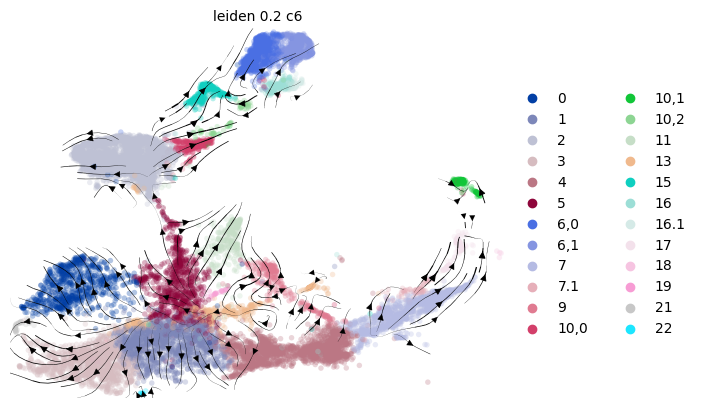

In [16]:
# Plot kernel vector field

combined_kernel.plot_projection(basis="umap", color="leiden_0.2_c6", legend_loc="right margin")

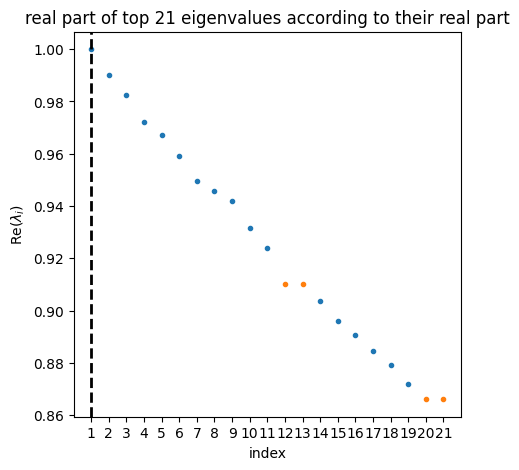

In [17]:
estimator = cellrank.estimators.GPCCA(combined_kernel)
estimator.compute_schur()
estimator.plot_spectrum(real_only=True)

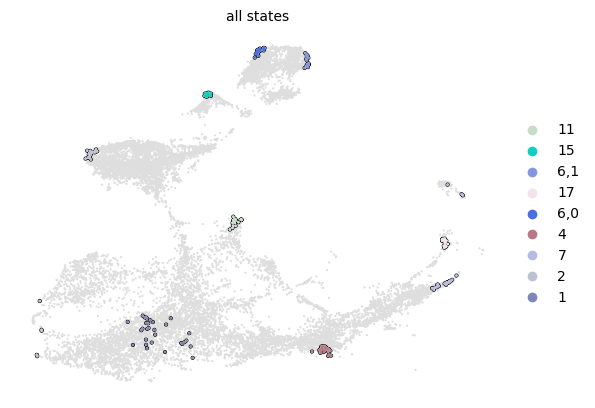

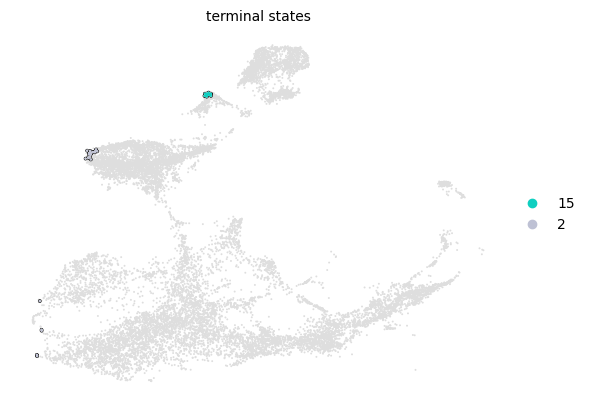

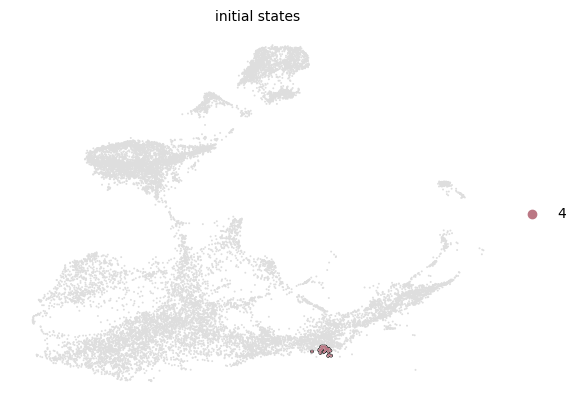

In [27]:
# Find macrostates
estimator.compute_macrostates(n_states=9, cluster_key="leiden_0.2_c6")

estimator.plot_macrostates(which="all", legend_loc="right", s=10, basis="umap")
macrostates = estimator.macrostates_memberships.names

# Predict terminal states

estimator.predict_terminal_states(stability_threshold=0.976)
estimator.plot_macrostates(which="terminal", legend_loc="right", discrete=True, basis="umap")
terminal_states = estimator.terminal_states_memberships.names

# Predict initial states

estimator.predict_initial_states(allow_overlap=True)
estimator.plot_macrostates(which="initial", legend_loc="right", basis="umap", discrete=True)
initial_states = estimator.initial_states_memberships.names

Cellrank finds reasonable start and end clusters if you exclude some clusters that are otherwise predicted to be initial states and cherrypick the number of clusters.

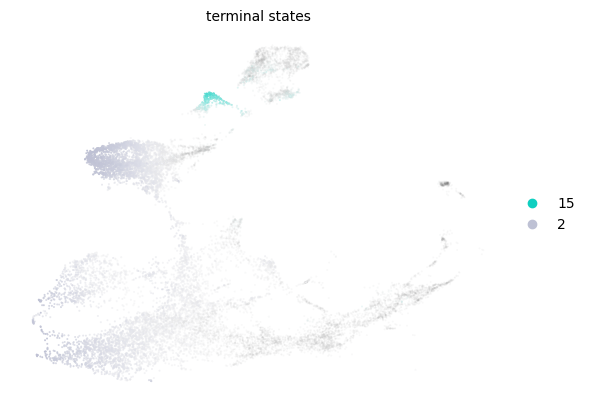

In [28]:
# Plot probability of cells belonging to the terminal states

estimator.plot_macrostates(which="terminal", legend_loc="right", discrete=False, basis="umap")

In [29]:
# Plot stability values. These are used to find terminal states with method="stability" and show that Day 4 control and Day 9 Hic2 OX are metastable

stability_values = estimator.coarse_T.values.diagonal()

stability_df = pandas.DataFrame({
    "Macrostate": macrostates,
    "Stability": stability_values
}).sort_values("Stability", ascending=False)

print(stability_df)

  Macrostate  Stability
7          2   0.983638
1         15   0.978859
3         17   0.975232
6          7   0.966891
4        6,0   0.966250
8          1   0.960290
5          4   0.959473
2        6,1   0.959432
0         11   0.958202


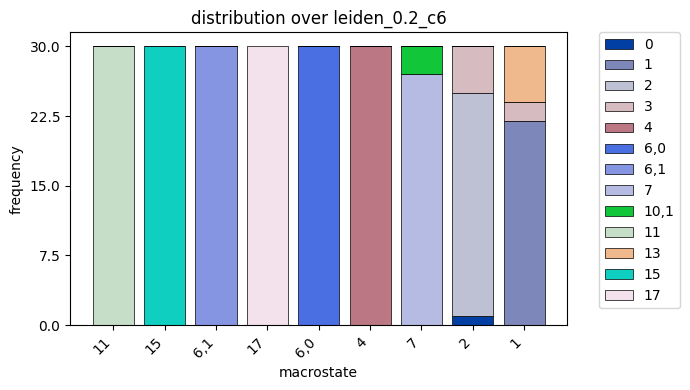

In [30]:
estimator.plot_macrostate_composition(key="leiden_0.2_c6", figsize=(7, 4))

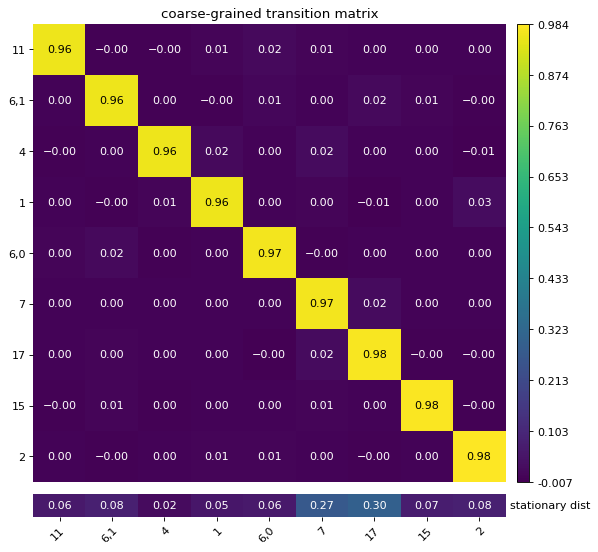

In [31]:
estimator.plot_coarse_T()

  0%|          | 0/2 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/2 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


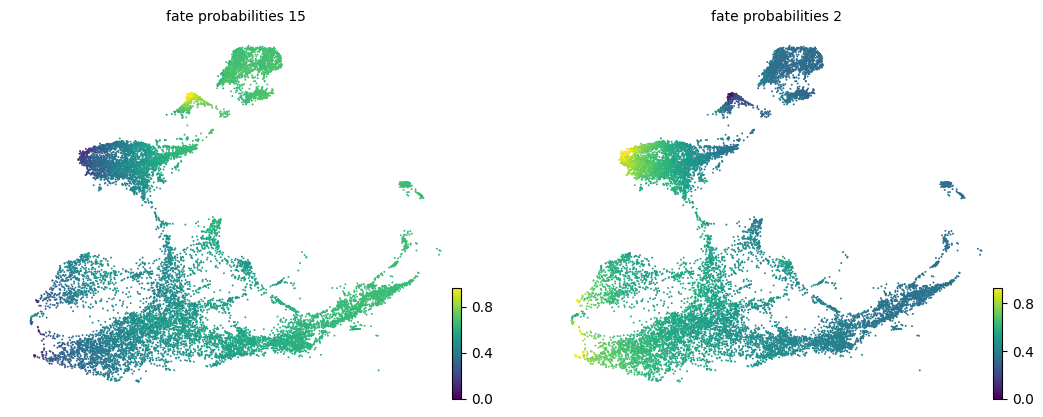

In [32]:
# Estimate fate probabilities

estimator.compute_fate_probabilities()

# Add fate probabilities to adata
for terminal_state in terminal_states:
    adata.obs[f"fate_probabilities_{terminal_state}"] = estimator.fate_probabilities[terminal_state].X.flatten()
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False, basis="umap")

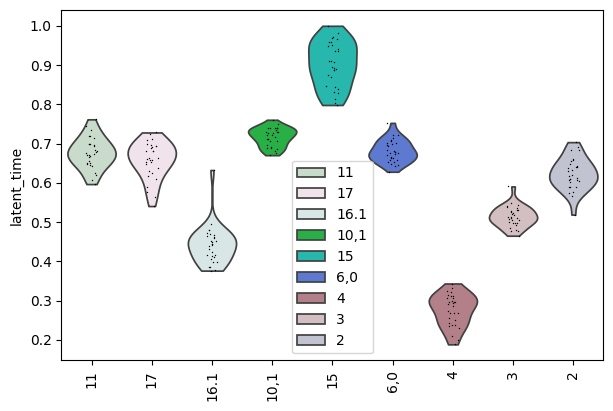

In [58]:
# Show macrostates in latent time

scanpy.pl.violin(adata, keys=["latent_time"], groupby="macrostates_fwd", rotation=90)

In [33]:
adata.var_names

Index(['PRDM16', 'AJAP1', 'RPL22', 'AL034417.2', 'MIR34AHG', 'VPS13D', 'DHRS3',
       'KAZN', 'IGSF21', 'MICOS10',
       ...
       'GPC4', 'GPC3', 'ARHGEF6', 'FGF13', 'LINC00632', 'AFF2', 'AF274853.1',
       'GABRA3', 'RPL10', 'F8'],
      dtype='object', length=2104)

  0%|          | 0/1 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


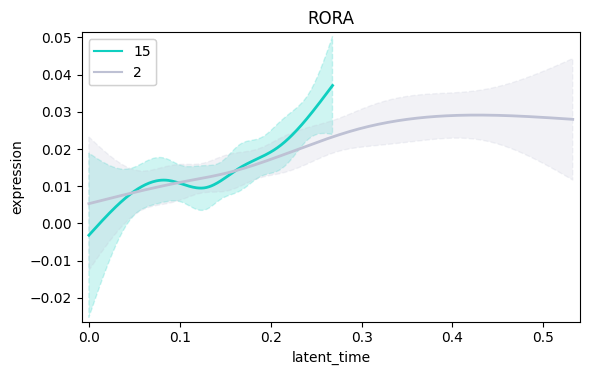

In [39]:
# Expression trends by trajectory

good_clusters = ["7", "7.1", "16.1", "6,0", "15"]

model = cellrank.models.GAMR(adata, n_knots=6, smoothing_penalty=10.0)

cellrank.pl.gene_trends(
    adata,
    model=model,
    genes=["RORA"],
    data_key="spliced",
    same_plot=True,
    ncols=4,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
)


# Save results

In [45]:
# Save results

base_name = "pv_cellrank_unitvelo"

adata.write_h5ad(
    working_directory+f"/{base_name}.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)